In [ ]:
import numpy as np
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot

In [ ]:
# WGAN requires gradient clipping for the critic model to clip the weights in a certain range
class ClipConstraint(Constraint):
  # set clip value when initialized
  def __init__(self, clip_value):
    self.clip_value = clip_value
  # clip model weights to hypercube
  def __call__(self, weights):
    return backend.clip(weights, -self.clip_value, self.clip_value)
  # get the config
  def get_config(self):
    return {'clip_value': self.clip_value}

In [ ]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
  return backend.mean(y_true*y_pred)

In [ ]:
# define standalone critic model
def define_critic(in_shape=(28,28,1)):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # weight constraint
  const = ClipConstraint(0.01)
  # define model
  model = Sequential()
  # downsample to 14x14
  model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  # downsample to 7x7
  model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  # scoring, linear activation
  model.add(Flatten())
  model.add(Dense(1))
  # compile model
  opt = RMSprop(lr=0.00005)
  model.compile(loss=wasserstein_loss, optimizer=opt)
  return model


In [ ]:
# define stand-alone generator model
def define_generator(latent_dim):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # define model
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128*7*7
  model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  # output 28x28x1
  model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
  return model


In [ ]:
# define the combines generator and critic model, for updating the generator
def define_gan(generator, critic):
  # make weights in the critic not trainable
  for layer in critic.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(generator)
  # add the critic
  model.add(critic)
  # compile model
  opt = RMSprop(lr=-.00005)
  model.compile(loss=wasserstein_loss, optimizer=opt)
  return model

In [ ]:
# load images
def load_real_samples():
 # load dataset
 (trainX, trainy), (_, _) = load_data()
 # select all of the examples for a given class
 selected_ix = trainy == 9
 X = trainX[selected_ix]
 # expand to 3d, e.g. add channels
 X = np.expand_dims(X, axis=-1)
 # convert from ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [-1,1]
 X = (X - 127.5) / 127.5
 return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
 # choose random instances
 ix = np.random.randint(0, dataset.shape[0], n_samples)
 # select images
 X = dataset[ix]
 # generate class labels, -1 for 'real'
 y = -np.ones((n_samples, 1))
 return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = np.random.randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
 # generate points in latent space
 x_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 X = generator.predict(x_input)
 # create class labels with 1.0 for 'fake'
 y = np.ones((n_samples, 1))
 return X, y


In [ ]:
# generate samples and save as a plot and save the model
def summarize_performances(step, g_model, latent_dim, n_samples=100):
  # prepare fake samples
  X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
  # scale from [-1,1] to [0,1]
  X = (X + 1) / 2.0
  # plot images
  for i in range(10*10):
    # define subplot
    pyplot.subplot(10, 10, 1+i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
  # save plot to file
  filename1 = 'generated_plot_%04d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  filename2 = 'model_%04d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))
  return X

In [ ]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
 # plot history
 pyplot.plot(d1_hist, label='crit_real')
 pyplot.plot(d2_hist, label='crit_fake')
 pyplot.plot(g_hist, label='gen')
 pyplot.legend()
 pyplot.savefig('plot_line_plot_loss.png')
 pyplot.close()

In [ ]:

def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128, n_critic=5):
  # calculate the number of batches per training epoch
  bat_per_epo = int(dataset.shape[0]/n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo*n_epochs
  # calculate the size of half batch of samples
  half_batch = int(n_batch/2)
  # lists for keeping track of loss
  c1_hist, c2_hist, g_hist = list(), list(), list()
  # manually enumerate epochs
  for i in range(n_steps):
    # update the critic more than the generator
    c1_tmp, c2_tmp = list(), list()
    for _ in range(n_critic):
      # get randomly selected 'real samples'
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update critic model weights
      c_loss1 = c_model.train_on_batch(X_real, y_real)
      c1_tmp.append(c_loss1)
      # generate fake examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update critic model weights
      c_loss2 = c_model.train_on_batch(X_fake, y_fake)
      c2_tmp.append(c_loss2)
    # store critic loss
    c1_hist.append(np.mean(c1_tmp))
    c2_hist.append(np.mean(c2_tmp))
    # prepare points in latent space as input for the generator
    X_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = -np.ones((n_batch, 1))
    # update the generator via the critic's error
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
    g_hist.append(g_loss)
    # summarize loss on this batch
    print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
    # evaluate the model performance every 'epoch'
    if (i+1) % bat_per_epo == 0:
      summarize_performances(i, g_model, latent_dim)
  plot_history(c1_hist, c2_hist, g_hist)



In [ ]:
# size of latent space
latent_dim = 50
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)

38/38 [==============================] - 0s 9ms/step
(1200, 28, 28, 1)


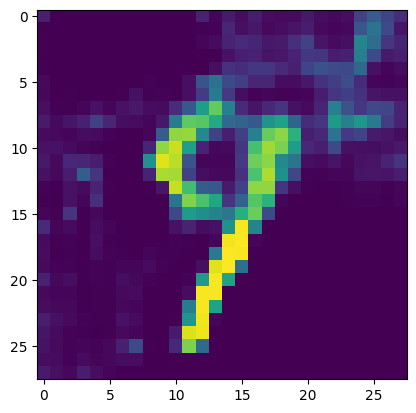

In [ ]:
X, _ = generate_fake_samples(generator, latent_dim, 1200)
print(X.shape)
pyplot.imshow(X[0])

In [ ]:
type(X)

numpy.ndarray

In [ ]:
np.savez("label_9_wgan.npz", data=X)